# Create a pipeline to perform batch inference utilizing a custom callback step
Amazon SageMaker Pipelines offers machine learning (ML) application developers and operations engineers the ability to orchestrate SageMaker jobs and author reproducible ML pipelines.

This notebook shows how to create a pipeline that reads the latest model registered in a model registry and perform batch transformation on data. <BR>
The architecture that this notebook builds is shown in the diagram below:

<IMG src="images/SM Pipelines callback and batch transform.png">


## Notebook Overview
This notebook shows how to:
- Define a CallBackStep that is able to integrate with almost any other AWS service outside the realm of SageMaker
- Create an SQS queue and a Lambda function that returns the latest model to be used by the transformation
- Define a CreateModelStep that makes use of the model returned by the lambda
- Define a TransformStep that creates a batch transform step using the latest model

As a prerequisite, you need a trained model and a dataset. <BR>
The pretrained model comes with this repository and is added to a new model registry as part of the Setup process. <BR>
A sample dataset is also downloaded and is uploaded to Amazon s3 as part of the Setup process. The data used is the [UCI Machine Learning Abalone Dataset](https://archive.ics.uci.edu/ml/datasets/abalone) [1]. The aim for this task is to determine the age of an abalone from its physical measurements. At the core, this is a regression problem. However, we will use a pretrained model, as training the machine learning model is outside the scope of this notebook. If interested to see how you could use SageMaker Pipelines to train a model for this use-case, the example [Orchestrating Jobs with Amazon SageMaker Model Building Pipelines](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-pipelines/tabular/abalone_build_train_deploy/sagemaker-pipelines-preprocess-train-evaluate-batch-transform.ipynb) shows exactly how to do this.


## Pre-Setup - IAM role setup
Before beginning running this Notebook you need to set the right permissions for everything to work. Specifically, in addition to the standard SageMaker permissions, what is needed is:
- Permissions to create an SQS queue and a lambda function
- A lambda role capable of reading from the queue and the model registry to the return the results to SageMaker

For simplicity, we will be using one role, the default SageMaker execution role, enhanced with the extra needed permissions. This is ***NOT*** advice on how to manage IAM policies/permissions on a production environment.

To get set-up, head over to the IAM Management Console, locate the AmazonSagemaker-ExecutionRole and add the following two permissions

<IMG src="images/iam_permissions.png">

Next, click on the Trust Relationships tab and add the following:

<IMG src="images/trust_relationship.png">

[1] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science.


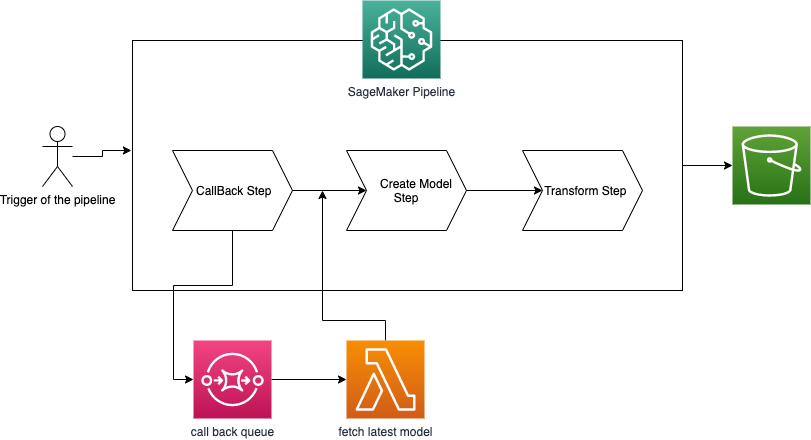

In [ ]:
!pip install "sagemaker>=2.45.0" --upgrade

In [ ]:
!pip install "boto3>=1.17.97" --upgrade

In [ ]:
import sagemaker
import boto3
from sagemaker import get_execution_role

sm_client = boto3.client(service_name="sagemaker")
role = get_execution_role()
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

In [ ]:
print(role)

In [ ]:
prefix = "batch-transform-with-callback-pipeline-demo"
model_package_group_name = "callbackBatchTransformPipelineModelPackageGroup"
sqs_queue_name = "callbackBatchTransformPipelineSQS"
lambda_function_name = "callbackBatchTransformPipelineLambda"
pipeline_name = "BatchTransformPipelineWithCallbackStep"

# Setup
There are certain preparatory steps we need to perform. 


First we assume that some other process/pipeline has trained a model, registered it in the Model Registry and someone has approved the model to be used for inference. <BR>
For this we are going to use a pretrained model and create and register model to a new Model Registry


Secondly, we assume that some other process is generating the dataset on which we want to perform the predictions and saved this in some s3 location known to us. <BR>
For this we are going to dowload a dataset from a public location and upload it to an s3 bucket that we will then provide as input to the pipeline. 

### Create a model registry and register model

Upload the model to Amazon s3

In [ ]:
base_uri = f"s3://{default_bucket}/{prefix}/trained_model"

model_location = sagemaker.s3.S3Uploader.upload(
    local_path="model.tar.gz",
    desired_s3_uri=base_uri,
)

image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost", region=region, version="1.0-1", py_version="py3"
)

Create a model package group and create a model package. Notice that we add the model directly with a status of `Approved`

In [ ]:
_ = sm_client.create_model_package_group(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageGroupDescription="Demo model package group",
)

In [ ]:
_ = sm_client.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelApprovalStatus="Approved",
    InferenceSpecification={
        "Containers": [
            {
                "Image": image_uri,
                "ModelDataUrl": model_location,
            },
        ],
        "SupportedTransformInstanceTypes": ["ml.m5.large"],
        "SupportedRealtimeInferenceInstanceTypes": ["ml.m5.large"],
        "SupportedContentTypes": [
            "text/csv",
        ],
        "SupportedResponseMIMETypes": [
            "text/csv",
        ],
    },
)

Checking that the model was registered successfully. The function `get_approved_model` will also be used by the lambda function later to find the latest approved model

In [ ]:
from utils import get_approved_package

get_approved_package(model_package_group_name)

### Collect data and upload to own Amazon s3 location

In [ ]:
local_path = "abalone-dataset-batch"

s3 = boto3.resource("s3")
s3.Bucket(f"sagemaker-servicecatalog-seedcode-{region}").download_file(
    "dataset/abalone-dataset-batch", local_path
)

base_uri = f"s3://{default_bucket}/{prefix}/batch_data"
batch_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)

# Create SQS Queue
This SQS Queue is used by the CallBackStep of the pipeline to publish a message to. Then the execution of the pipeline pauses until this message is consumed (by any service that is configured to consume this queue - in this case a lambda).

In [ ]:
sqs_client = boto3.client("sqs")
sqs_client.create_queue(QueueName=sqs_queue_name)

queue_url = sqs_client.get_queue_url(QueueName=sqs_queue_name)["QueueUrl"]
queue_arn = sqs_client.get_queue_attributes(QueueUrl=queue_url, AttributeNames=["QueueArn"])[
    "Attributes"
]["QueueArn"]

# Create Lambda (Consumer of the queue)
This lambda function is configured to read messages from the newly created queue, retrieves the latest approved model and then returns the retrieved details of the model along a success message to the pipeline so that it continues execution.


Since the CallBackStep functionality was introduced at version of `1.17.97` in boto3, in order for the lambda function to return a success message & output to the pipeline we need to be using at least that version of boto3. <BR>
Since the current runtime of lambda is an older version (check [this](https://docs.aws.amazon.com/lambda/latest/dg/lambda-python.html)) we need to create a lambda layer with the latest boto3 version. If you are not familiar with lambda layers, it is essentially an archive containing additional code, such as libraries, dependencies, or even custom runtimes. This [blogpost](https://aws.amazon.com/blogs/compute/using-lambda-layers-to-simplify-your-development-process/#:~:text=A%20Lambda%20layer%20is%20an,dependencies%2C%20or%20even%20custom%20runtimes.&text=By%20moving%20runtime%20dependencies%20from,archive%20uploaded%20during%20a%20deployment.) might help.

### Create lambda layer
To create the layer, we are <i>installing</i> the latest boto3 version in a local folder and we zip this folder in a file that is then used to publish the layer

*`%%capture` is added to suppress the output of the following commands sine that is very long. Feel free to comment out to view all output


In [ ]:
%%capture

!mkdir boto3-mylayer
!pip install boto3 -t ./latestboto3

!apt-get update
!apt-get install zip

!zip -r latestboto3.zip latestboto3/

In [ ]:
lambda_client = boto3.client("lambda")

with open("latestboto3.zip", "rb") as file_data:
    bytes_content = file_data.read()

layer_name = "myboto3layer"
lambda_layer = lambda_client.publish_layer_version(
    LayerName=layer_name, Content={"ZipFile": bytes_content}
)
layer_version_arn = lambda_layer["LayerVersionArn"]
layer_version_number = lambda_layer["Version"]

### Create the lambda function

Take a look at the core part of the lambda function below. <BR>
The lambda function does exactly 3 things. 
1. Retrieves a token from the message - this is originally inserted by the callBackStep of the Pipeline (will see that later)
2. Retrieves the latest model from the registry. We are particularly interested in the Image URI and the Model artifact location
3. Returns the model details along with the token to the pipeline by calling the `send_pipeline_execution_step_success` function

In [ ]:
!sed -n '18,49p' < utils.py | pygmentize -l python

In [ ]:
lambda_client = boto3.client("lambda")


def lambda_file():
    import os
    from zipfile import ZipFile

    filename = "lambdacode.zip"

    zipObj = ZipFile(filename, "w")
    zipObj.write("utils.py")
    zipObj.close()

    with open(filename, "rb") as file_data:
        bytes_content = file_data.read()
    return bytes_content


lambda_client.create_function(
    FunctionName=lambda_function_name,
    Runtime="python3.8",
    Role=role,
    Handler="utils.handler",
    Code={"ZipFile": lambda_file()},
    Publish=True,
    PackageType="Zip",
    Layers=[layer_version_arn],
    Environment={"Variables": {"ModelPackageGroupName": model_package_group_name}},
)

### Create event source mapping
This event source mapping is triggering the lambda function on arrival of a new message to the SQS queue

In [ ]:
event_source_mapping = lambda_client.create_event_source_mapping(
    EventSourceArn=queue_arn, FunctionName=lambda_function_name, Enabled=True
)

event_mapping_uuid = event_source_mapping["UUID"]

# Build pipeline
We are now building the SageMaker Pipeline.

In [ ]:
from sagemaker.workflow.parameters import ParameterString

batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri,
)
sqs_queue_to_use = ParameterString(
    name="SQSQueue",
    default_value=sqs_queue_name,
)

In [ ]:
from sagemaker.workflow.callback_step import CallbackStep, CallbackOutput, CallbackOutputTypeEnum

step_latest_model_fetch = CallbackStep(
    name="fetchLatestModel",
    sqs_queue_url=sqs_queue_to_use,
    inputs={},
    outputs=[
        CallbackOutput(output_name="ModelUrl", output_type=CallbackOutputTypeEnum.String),
        CallbackOutput(output_name="ImageUri", output_type=CallbackOutputTypeEnum.String),
    ],
)

In [ ]:
from sagemaker.model import Model

model = Model(
    image_uri=step_latest_model_fetch.properties.Outputs["ImageUri"],
    model_data=step_latest_model_fetch.properties.Outputs["ModelUrl"],
    sagemaker_session=sagemaker_session,
    role=role,
)

In [ ]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.steps import CreateModelStep


inputs = CreateModelInput(
    instance_type="ml.m5.large",
)
step_create_model = CreateModelStep(
    name="CreateModel",
    model=model,
    inputs=inputs,
)

In [ ]:
from sagemaker.transformer import Transformer


transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.large",
    instance_count=1,
    output_path=f"s3://{default_bucket}/AbaloneTransform",
)

In [ ]:
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep


step_transform = TransformStep(
    name="Transform", transformer=transformer, inputs=TransformInput(data=batch_data)
)

In [ ]:
from sagemaker.workflow.pipeline import Pipeline


pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        batch_data,
        sqs_queue_to_use,
    ],
    steps=[step_latest_model_fetch, step_create_model, step_transform],
)

In [ ]:
import json


definition = json.loads(pipeline.definition())
# definition

# Execute pipeline

In [ ]:
pipeline.upsert(role_arn=role)

In [ ]:
execution = pipeline.start()

Once you start the execution of the pipeline, head over to the Pipelines SageMaker Resources (shown in the picture below)


<IMG src="images/pipelineexecution.png" />

Feel free to double-click on the executing pipeline to get more details on the progress of the execution.
The pipeline will be finished and marked green, in about 4 minutes.

In [ ]:
# execution.stop()

# Clean-up
Run the following steps to delete all resources created by this example. <BR>
Please note that the following are not deleting data from your Amazon s3 bucket, including the original trained model, the original data, the transformed data as well as any intermediate data created by the Pipeline Steps

In [ ]:
sm_client.delete_pipeline(PipelineName=pipeline_name)

In [ ]:
from utils import get_approved_package

arn_of_model_to_delete = get_approved_package(model_package_group_name)["ModelPackageArn"]
sm_client.delete_model_package(
    ModelPackageName=arn_of_model_to_delete,
)
sm_client.delete_model_package_group(
    ModelPackageGroupName=model_package_group_name,
)

In [ ]:
sqs_client.delete_queue(QueueUrl=queue_url)

In [ ]:
lambda_client.delete_event_source_mapping(UUID=event_mapping_uuid)

In [ ]:
lambda_client.delete_function(FunctionName=lambda_function_name)

In [ ]:
lambda_client.delete_layer_version(LayerName=layer_name, VersionNumber=layer_version_number)

In [ ]:
!rm -rf latestboto3/

In [ ]:
!rm latestboto3.zip

In [ ]:
!rm lambdacode.zip